In [1]:
import pandas as p
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import bert
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))

In [2]:
%store -r data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1600000 non-null  int64 
 1   ids         1600000 non-null  int64 
 2   date        1600000 non-null  object
 3   flag        1600000 non-null  object
 4   user        1600000 non-null  object
 5   text        1600000 non-null  object
 6   clean_text  1600000 non-null  object
dtypes: int64(2), object(5)
memory usage: 85.4+ MB


In [3]:
X = data['clean_text'].values
y = data['target'].values
y = np.array([i if i == 0 else 1 for i in y])
print(len(X))
print(len(y))

1600000
1600000


In [4]:
X_train, X_validation_test, y_train, y_validation_test = train_test_split(X, y, test_size=0.02, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_test, y_validation_test, test_size=0.5, random_state=0)
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)
np.unique(y_train, return_counts=True)

(1568000,) (1568000,) (16000,) (16000,) (16000,) (16000,)


(array([0, 1], dtype=int64), array([783999, 784001], dtype=int64))

In [5]:
def get_bert_details(bert_path, max_seq):
    
    bert_layer = hub.KerasLayer(bert_path, trainable=False)
    vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = bert.bert_tokenization.FullTokenizer(vocabulary_file, to_lower_case)

    input_word_ids = tf.keras.layers.Input(shape=(max_seq,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.layers.Input(shape=(max_seq,), dtype=tf.int32, name='input_mask')
    segment_ids = tf.keras.layers.Input(shape=(max_seq,), dtype=tf.int32, name='segment_ids')
    bert_inputs = [input_word_ids, input_mask, segment_ids]
    pooled_output, sequence_output = bert_layer(bert_inputs)
    
    return tokenizer, bert_inputs, pooled_output, sequence_output 

In [6]:
def get_masks(tokens, max_seq):
    return [1]*len(tokens) + [0] * (max_seq - len(tokens))

In [7]:
def get_segments(tokens, max_seq):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == '[SEP]':
            current_segment_id = 1
    return segments + [0] * (max_seq - len(tokens))

In [8]:
def get_ids(tokens, tokenizer, max_seq):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq - len(token_ids))
    return input_ids

In [9]:
def create_single_input(sentence, tokenizer, max_len, max_seq):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:max_len]
    stokens = ['[CLS]'] + stokens + ['[SEP]']
    ids = get_ids(stokens, tokenizer, max_seq)
    masks = get_masks(stokens, max_seq)
    segments = get_segments(stokens, max_seq)
    return ids, masks, segments

In [10]:
def create_input_array(sentences, tokenizer, max_seq):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences, position=0, leave=True):
        ids, masks, segments = create_single_input(sentence, tokenizer, max_seq-2, max_seq)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return np.asarray(input_ids, dtype=np.int32), np.asarray(input_masks, dtype=np.int32), np.asarray(input_segments, dtype=np.int32)

In [11]:
def prepare_data(tokenizer, max_seq, padding_type):
    
    ids, masks, segments = create_input_array(X_train, tokenizer, max_seq)
    train_padded = [tf.keras.preprocessing.sequence.pad_sequences(ids, padding=padding_type, maxlen=max_seq), masks, segments]

    ids, masks, segments = create_input_array(X_validation, tokenizer, max_seq)
    validation_padded = [tf.keras.preprocessing.sequence.pad_sequences(ids, padding=padding_type, maxlen=max_seq), masks, segments]

    ids, masks, segments = create_input_array(X_test, tokenizer, max_seq)
    test_padded = [tf.keras.preprocessing.sequence.pad_sequences(ids, padding=padding_type, maxlen=max_seq), masks, segments]

    training_label_seq = np.array(y_train)
    validation_label_seq = np.array(y_validation)
    test_label_seq = np.array(y_test)
    
    return train_padded, training_label_seq, validation_padded, validation_label_seq, test_padded, test_label_seq

In [12]:
def plot_graphs(history, string):
  plt.plot(range(1, len(history.history[string])+1), history.history[string])
  plt.plot(range(1, len(history.history['val_'+string])+1), history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [13]:
def save_model(model, name):
    model_json = model.to_json()
    with open(name + '.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(name + '.h5')
    print('Saved model to disk')

In [14]:
def load_model(name):
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={'KerasLayer': hub.KerasLayer})
    loaded_model.load_weights(name + '.h5')
    print('Loaded model from disk')
    return loaded_model

In [19]:
# compile model
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
max_seq = 64
padding_type='post'

tokenizer, bert_inputs, pooled_output, sequence_output = get_bert_details(bert_path, max_seq)
train_padded, training_label_seq, validation_padded, validation_label_seq, test_padded, test_label_seq = prepare_data(tokenizer, max_seq, padding_type)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(sequence_output)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=bert_inputs, outputs=output)
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 6294.15it/s]


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [30]:
# train model
num_epochs = 2
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 21152s 13ms/sample - loss: 0.4059 - accuracy: 0.8144 - val_loss: 0.3880 - val_accuracy: 0.8222
Epoch 2/2
1568000/1568000 [==============================] - 22834s 15ms/sample - loss: 0.3761 - accuracy: 0.8310 - val_loss: 0.3813 - val_accuracy: 0.8259


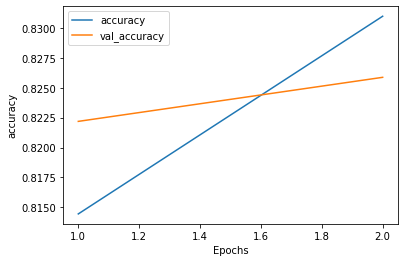

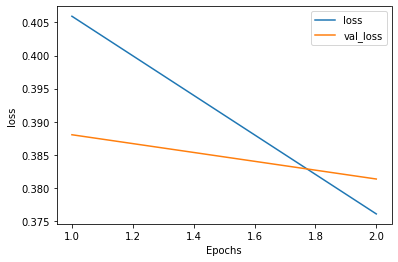

In [31]:
# plot model
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
# evaluate model
scores = model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

16000/16000 [==============================] - 253s 16ms/sample - loss: 0.3792 - accuracy: 0.8294
accuracy: 82.94%


In [33]:
# save model
save_model(model, 'modelBertL12')

Saved model to disk


In [ ]:
# load model
loaded_model = load_model('modelBertL12')

# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [15]:
# compile model
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
max_seq = 40
padding_type='post'

tokenizer, bert_inputs, pooled_output, sequence_output = get_bert_details(bert_path, max_seq)
train_padded, training_label_seq, validation_padded, validation_label_seq, test_padded, test_label_seq = prepare_data(tokenizer, max_seq, padding_type)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(sequence_output)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model2 = tf.keras.models.Model(inputs=bert_inputs, outputs=output)
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 6453.21it/s]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [16]:
# train model
num_epochs = 2
history2 = model2.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 33930s 22ms/sample - loss: 0.4028 - accuracy: 0.8162 - val_loss: 0.3846 - val_accuracy: 0.8251
Epoch 2/2
1568000/1568000 [==============================] - 16219s 10ms/sample - loss: 0.3723 - accuracy: 0.8334 - val_loss: 0.3773 - val_accuracy: 0.8298


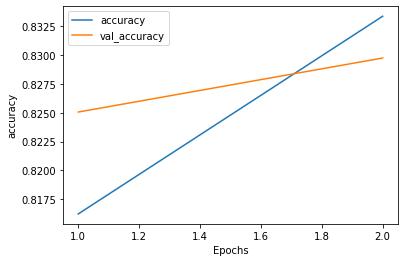

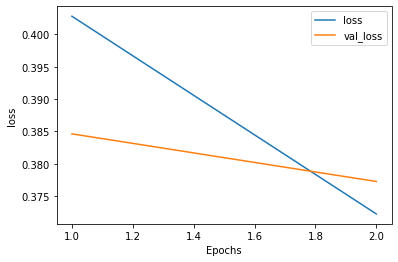

In [17]:
# plot model
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [18]:
# evaluate model
scores2 = model2.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model2.metrics_names[1], scores2[1]*100))

16000/16000 [==============================] - 317s 20ms/sample - loss: 0.3762 - accuracy: 0.8328
accuracy: 83.28%


In [19]:
# save model
save_model(model2, 'model2BertL12')

Saved model to disk


In [22]:
# load model
loaded_model = load_model('model2BertL12')
 
# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
16000/16000 [==============================] - 126s 8ms/sample - loss: 0.3762 - accuracy: 0.8328
accuracy: 83.28%


In [15]:
# compile model
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
max_seq = 40
padding_type='post'

tokenizer, bert_inputs, pooled_output, sequence_output = get_bert_details(bert_path, max_seq)
train_padded, training_label_seq, validation_padded, validation_label_seq, test_padded, test_label_seq = prepare_data(tokenizer, max_seq, padding_type)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True))(sequence_output)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024))(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model3 = tf.keras.models.Model(inputs=bert_inputs, outputs=output)
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model3.summary()

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 6604.09it/s]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [16]:
# train model
num_epochs = 2
history3 = model3.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 28095s 18ms/sample - loss: 0.4006 - accuracy: 0.8175 - val_loss: 0.3838 - val_accuracy: 0.8276
Epoch 2/2
1568000/1568000 [==============================] - 27812s 18ms/sample - loss: 0.3704 - accuracy: 0.8346 - val_loss: 0.3769 - val_accuracy: 0.8298


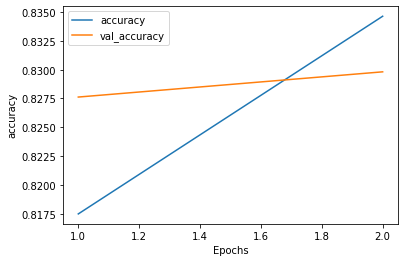

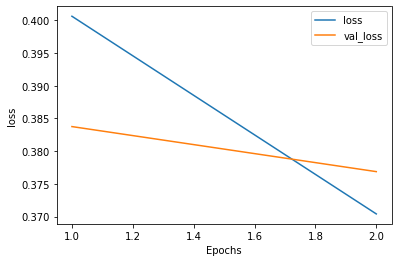

In [17]:
# plot model
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

In [18]:
# evaluate model
scores3 = model3.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model3.metrics_names[1], scores3[1]*100))

16000/16000 [==============================] - 165s 10ms/sample - loss: 0.3757 - accuracy: 0.8339
accuracy: 83.39%


In [19]:
# save model
save_model(model3, 'model3BertL12')

Saved model to disk


In [ ]:
# load model
loaded_model = load_model('model3BertL12')
 
# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [19]:
# compile model
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
max_seq = 40
padding_type='post'

tokenizer, bert_inputs, pooled_output, sequence_output = get_bert_details(bert_path, max_seq)
train_padded, training_label_seq, validation_padded, validation_label_seq, test_padded, test_label_seq = prepare_data(tokenizer, max_seq, padding_type)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model4 = tf.keras.models.Model(inputs=bert_inputs, outputs=output)
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [20]:
# train model
num_epochs = 2
history4 = model4.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 12499s 8ms/sample - loss: 0.4083 - accuracy: 0.8135 - val_loss: 0.3948 - val_accuracy: 0.8209
Epoch 2/2
1568000/1568000 [==============================] - 13647s 9ms/sample - loss: 0.3803 - accuracy: 0.8286 - val_loss: 0.3838 - val_accuracy: 0.8274


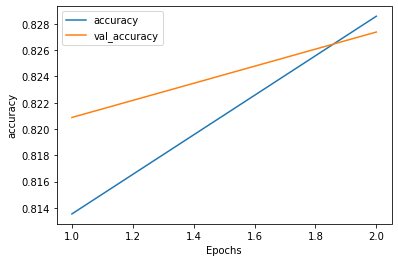

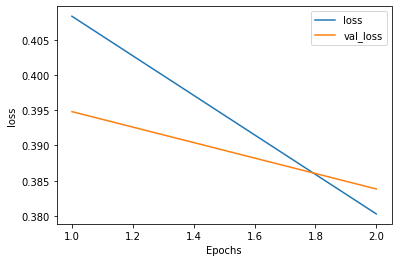

In [21]:
# plot model
plot_graphs(history4, "accuracy")
plot_graphs(history4, "loss")

In [22]:
# evaluate model
scores4 = model4.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model4.metrics_names[1], scores4[1]*100))

16000/16000 [==============================] - 101s 6ms/sample - loss: 0.3818 - accuracy: 0.8275
accuracy: 82.75%


In [23]:
# save model
save_model(model4, 'model4BertL12')

Saved model to disk


In [ ]:
# load model
loaded_model = load_model('model4BertL12')
 
# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [15]:
# compile model
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
max_seq = 40
padding_type='post'

tokenizer, bert_inputs, pooled_output, sequence_output = get_bert_details(bert_path, max_seq)
train_padded, training_label_seq, validation_padded, validation_label_seq, test_padded, test_label_seq = prepare_data(tokenizer, max_seq, padding_type)

x = tf.keras.layers.Dense(1024, activation='relu')(pooled_output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model5 = tf.keras.models.Model(inputs=bert_inputs, outputs=output)
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model5.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model5.summary()

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 6350.42it/s]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [16]:
# train model
num_epochs = 2
history5 = model5.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 13878s 9ms/sample - loss: 0.5164 - accuracy: 0.7437 - val_loss: 0.4957 - val_accuracy: 0.7558
Epoch 2/2
1568000/1568000 [==============================] - 13784s 9ms/sample - loss: 0.4954 - accuracy: 0.7581 - val_loss: 0.4900 - val_accuracy: 0.7614


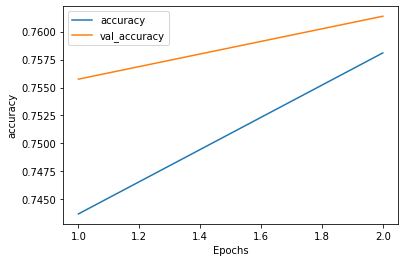

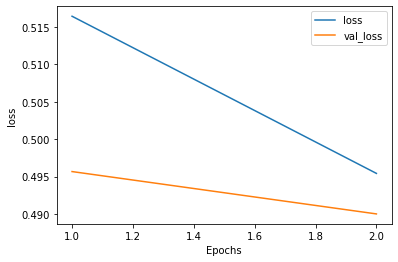

In [17]:
# plot model
plot_graphs(history5, "accuracy")
plot_graphs(history5, "loss")

In [18]:
# evaluate model
scores5 = model5.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model5.metrics_names[1], scores5[1]*100))

16000/16000 [==============================] - 106s 7ms/sample - loss: 0.4875 - accuracy: 0.7628
accuracy: 76.28%


In [19]:
# save model
save_model(model5, 'model5BertL12')

Saved model to disk


In [20]:
# load model
loaded_model = load_model('model5BertL12')
 
# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
16000/16000 [==============================] - 98s 6ms/sample - loss: 0.4875 - accuracy: 0.7628
accuracy: 76.28%
